In [88]:
import numpy as np
import sys
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

extra_path = '/p/project/cjibg36/kaandorp2/Git/SLOTH' 
if extra_path not in sys.path:
    sys.path.append(extra_path)

from sloth.IO import readSa, writeSa

realization = 0

In [89]:
file_indi = '/p/project/cjibg36/kaandorp2/TSMP_patched/tsmp_cordex_111x108/input_pf/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_111x108_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGR3_alv.sa'
file_Ks_out = '/p/project/cjibg36/kaandorp2/TSMP_patched/tsmp_cordex_111x108_KsKriged/input_pf/Ks_kriged.sa'
mode = 'ml' #rnd or ml

Ks_water = -5 #log10 value 
Ks_allv = False #log10 value (-1) or False
indi_water = 21
indi_allv = 13

X_train = np.load('Ks.static.npy')
Y_train = np.load('Ks.param.npy')
kernel = 1.0 * Matern(length_scale=20,nu=1.5,length_scale_bounds='fixed')

data_indi = readSa(file_indi)
indi_dz = 2*np.array([9.0,7.5,5.0,5.0,2.0,0.5,0.35,0.25,0.15,0.10,0.065,0.035,0.025,0.015,0.01])
indi_depths = np.flip(np.cumsum(np.flip(indi_dz)))

if mode == 'rnd':
    rnd_seed = np.random.randint(100)
    realization += 1
    
i_sample_z = np.unique(X_train[:,0])
plot = True
if plot:
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors

In [90]:
def fit_gprs(i_sample_z,X_train,Y_train):
    
    gprs_ = {} 

    for i1, i_sample in enumerate(i_sample_z): #only train the GPR on several layers
        mask = X_train[:,0] == i_sample
        X_train_ = X_train[mask,1:]
        Y_train_ = Y_train[mask,0]
        Y_sigma_ = Y_train[mask,1]
        gprs_[i_sample] = GaussianProcessRegressor(kernel=kernel,alpha=1.*(Y_sigma_**2))
        gprs_[i_sample].fit(X_train_, Y_train_)
    
    return gprs_

gprs = fit_gprs(i_sample_z,X_train,Y_train)

Generating Ks for layer 0
Generating Ks for layer 1
Generating Ks for layer 2
Generating Ks for layer 3
Generating Ks for layer 4
Generating Ks for layer 5
Generating Ks for layer 6
Generating Ks for layer 7
Generating Ks for layer 8
Generating Ks for layer 9
Generating Ks for layer 10
Generating Ks for layer 11
Generating Ks for layer 12
Generating Ks for layer 13
Generating Ks for layer 14


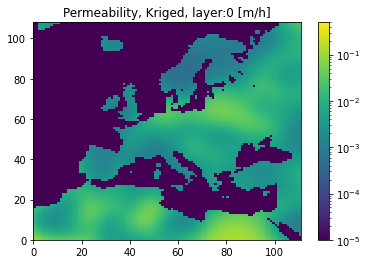

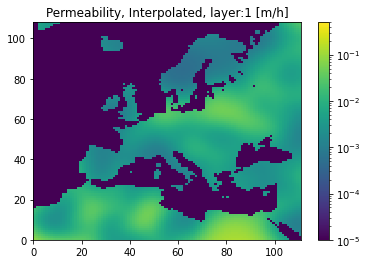

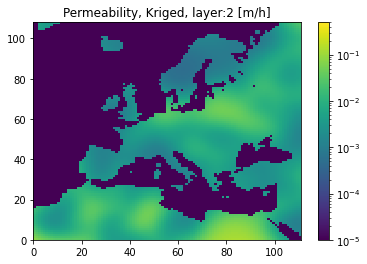

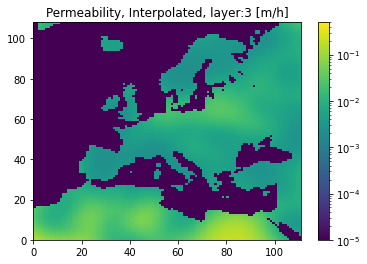

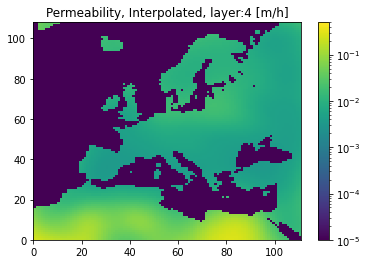

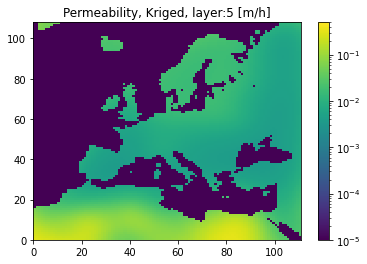

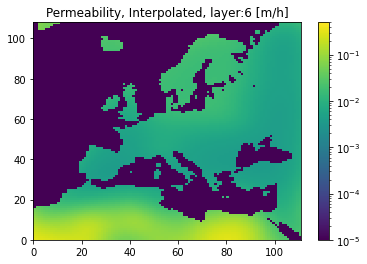

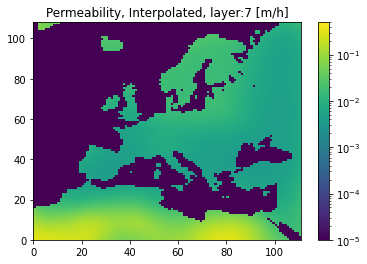

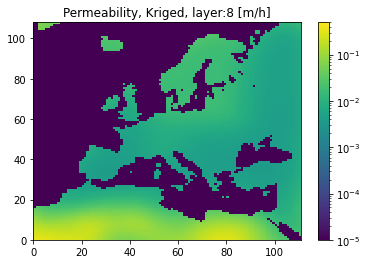

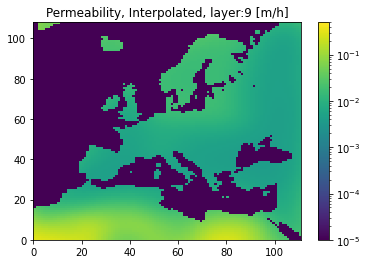

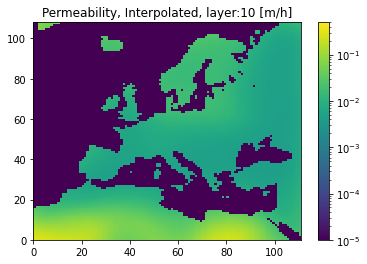

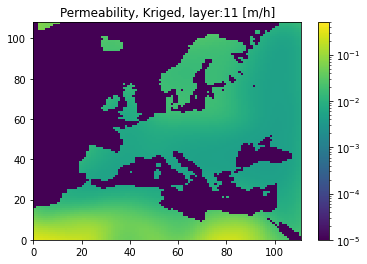

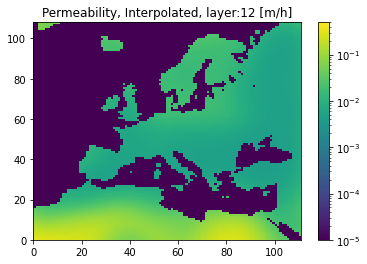

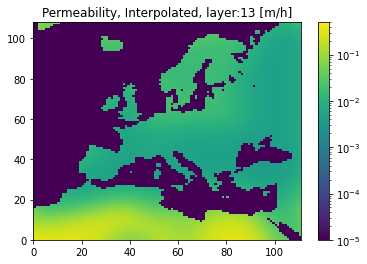

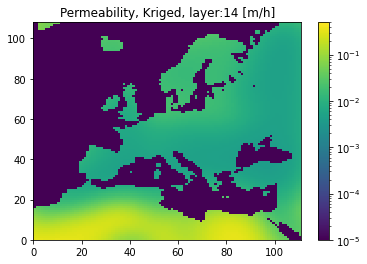

In [91]:
Ks_field = np.nan*np.zeros(data_indi.shape)

X = np.meshgrid(np.arange(0,Ks_field.shape[1]),
                np.arange(0,Ks_field.shape[2]),indexing='ij')

i_lower_old = np.inf
Ks_field_upper = np.nan*np.zeros(X[0].shape)
Ks_field_lower = np.nan*np.zeros(X[0].shape)

for i_layer in range(Ks_field.shape[0]):
    print('Generating Ks for layer %i' % i_layer)
    mask_land = (data_indi[i_layer,:] < 20)
    X_test = np.array([X[0][mask_land],
                    X[1][mask_land]]).T


    # layer is sampled -> Kriging
    if i_layer in i_sample_z:
        if mode == 'ml':
            Ks_ = gprs[i_layer].predict(X_test)
        elif mode == 'rnd':
            Ks_ = gprs[i_layer].sample_y(X_test,random_state=rnd_seed)[:,0]
        else:
            raise RuntimeError('Mode should be ml (most likely) or rnd (random)')
        Ks_field[i_layer,mask_land] = Ks_
    
    # layer is not sampled -> interpolate linearly
    else:
        i_lower = i_sample_z[np.digitize(i_layer,i_sample_z) - 1]
        i_upper = i_sample_z[np.digitize(i_layer,i_sample_z)]
    
        if i_lower == i_lower_old:
            # predictions for upper/lower fields already made, skip
            pass
        else:
            if mode == 'ml':
                Ks_upper = gprs[i_upper].predict(X_test)
                Ks_lower = gprs[i_lower].predict(X_test)
            elif mode == 'rnd':
                Ks_upper = gprs[i_upper].sample_y(X_test,random_state=rnd_seed)[:,0]
                Ks_lower = gprs[i_lower].sample_y(X_test,random_state=rnd_seed)[:,0]
                
            Ks_field_upper[mask_land] = Ks_upper
            Ks_field_lower[mask_land] = Ks_lower
            i_lower_old = i_lower
  
        z_upper = indi_depths[i_upper]
        z_lower = indi_depths[i_lower]
        z_interp = indi_depths[i_layer]

        assert(z_upper < z_lower)
        assert(z_interp > z_upper)

        Ks_interp = ( ((z_interp - z_upper) / (z_lower - z_upper)) * Ks_lower) + ( ((z_lower - z_interp) / (z_lower - z_upper)) * Ks_upper)
        Ks_field[i_layer,mask_land] = Ks_interp    

Ks_field[data_indi >= indi_water] = Ks_water
if Ks_allv:
    Ks_field[data_indi == indi_allv] = Ks_allv
Ks_field = 10**Ks_field
    
writeSa(file_Ks_out,Ks_field)

if plot:
    for i_layer in range(Ks_field.shape[0]):
        plt.figure()
        plt.pcolormesh(Ks_field[i_layer,:,:],norm=colors.LogNorm(vmin=1e-5, vmax=.5) )
        plt.colorbar()
        if i_layer in i_sample_z:
            method_ = 'Kriged'
        else:
            method_ = 'Interpolated'
        plt.title('Permeability, %s, layer:%i [m/h]' % (method_,i_layer) )
        plt.savefig('figures/Ks_real%3.3i_%3.3i.png'% (realization,i_layer) )



In [83]:
if plot:
    for i_layer in range(Ks_field.shape[0]):
        plt.figure()
        plt.pcolormesh(Ks_field[i_layer,:,:],norm=colors.LogNorm(vmin=1e-5, vmax=.5) )
        plt.colorbar()
        if i_layer in i_sample_z:
            method_ = 'Kriged'
        else:
            method_ = 'Interpolated'
        plt.title('Permeability, %s, layer:%i [m/h]' % (method_,i_layer) )
        plt.savefig('figures/Ks_real%3.3i_%3.3i.png'% (realization,i_layer) )


In [72]:
Ks_field[i_layer,mask_land].shape

(6503,)

In [69]:
rnd_seed

7

In [84]:
data = readSa('/p/project/cjibg36/kaandorp2/TSMP_patched/tsmp_cordex_111x108_KsField/input_pf/Ks.sa')
data.shape

(15, 108, 111)

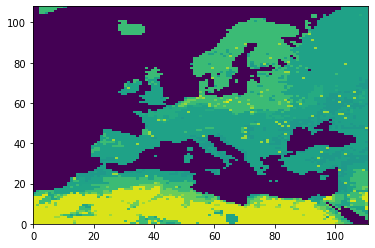

In [87]:
%matplotlib inline
plt.figure()
plt.pcolormesh(data[-1,:,:],norm=colors.LogNorm(vmin=1e-5, vmax=.5))